In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

C:\Users\pioac\AppData\Local\Temp\ipykernel_35704\3916181912.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'datetime': pd.date_range("2024-01-01", periods=len(synthetic_data), freq='H'),
c:\Users\pioac\miniconda3\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 10.3397
Epoch 2/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5260
Epoch 3/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0905
Epoch 4/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0255
Epoch 5/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102
Epoch 6/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083
Epoch 7/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 8/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076
Epoch 9/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065
Epoch 10/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062
Epoch 11/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061
Epoch 12/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058
Epoch 13/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059
Epoch 14/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053
Epoch 15/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052
Epoch 16/80
18/18

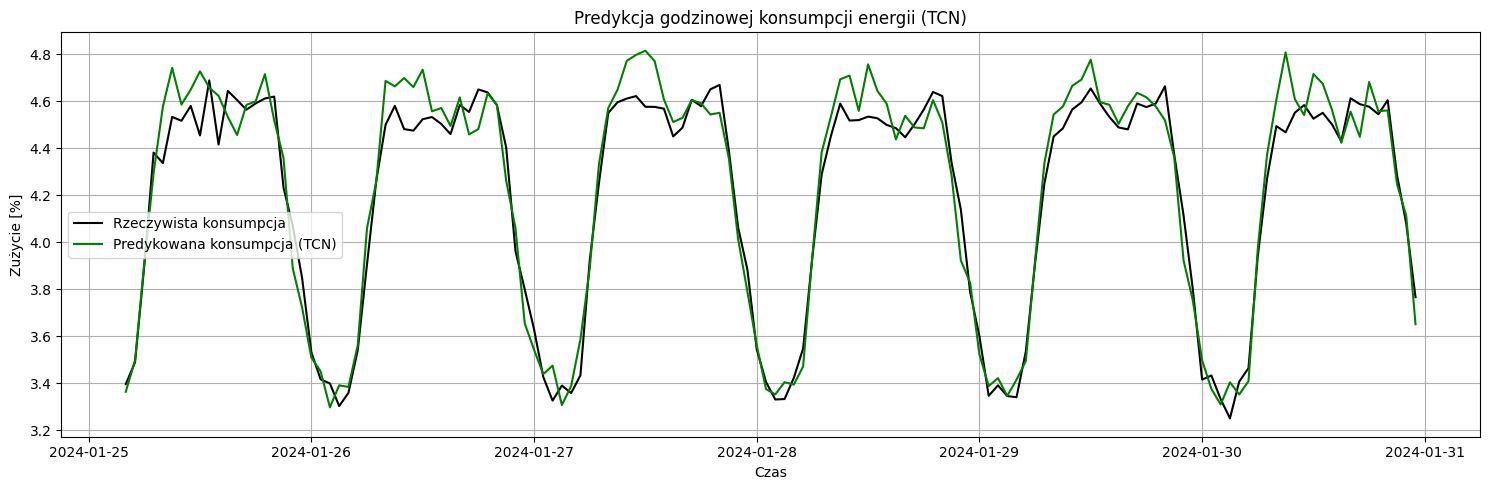

                   Czas  Rzeczywista konsumpcja  Predykowana konsumpcja  \
0   2024-01-25 04:00:00                3.396821                3.364307   
1   2024-01-25 05:00:00                3.490216                3.498076   
2   2024-01-25 06:00:00                3.902535                3.914566   
3   2024-01-25 07:00:00                4.382188                4.295745   
4   2024-01-25 08:00:00                4.337494                4.577545   
..                  ...                     ...                     ...   
135 2024-01-30 19:00:00                4.545439                4.557971   
136 2024-01-30 20:00:00                4.604990                4.561732   
137 2024-01-30 21:00:00                4.288002                4.248971   
138 2024-01-30 22:00:00                4.079573                4.113207   
139 2024-01-30 23:00:00                3.767246                3.652236   

      Różnica  
0   -0.032514  
1    0.007860  
2    0.012031  
3   -0.086443  
4    0.240051  
.. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1. Wczytanie danych ===
df = pd.read_csv(r"Profil_konsumpcji\profil_konsumpcji_godzinowo.csv")
df.columns = ['Hour', 'Load']
df['Hour'] = pd.to_datetime(df['Hour'].str.split(' - ').str[0], format='%H:%M').dt.time

# Jeśli masz dane tylko z jednego dnia – to powiel je np. 30 razy z lekkim szumem, żeby mieć więcej danych
hours = df['Hour'].tolist()
base_values = df['Load'].values

# Generujemy sztuczne dane na 30 dni (24h * 30 = 720 punktów)
synthetic_data = []
for day in range(30):
    daily_noise = np.random.normal(0, 0.05, len(base_values))
    new_day = base_values + daily_noise
    synthetic_data.extend(new_day)

full_df = pd.DataFrame({
    'datetime': pd.date_range("2024-01-01", periods=len(synthetic_data), freq='H'),
    'load': synthetic_data
})

# === 2. Skalowanie ===
scaler = MinMaxScaler()
scaled_load = scaler.fit_transform(full_df[['load']])

# === 3. Tworzenie sekwencji (np. 24h do przodu na podstawie ostatnich 24h) ===
def create_sequences(data, n_steps=24):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 24
X, y = create_sequences(scaled_load, n_steps)

# === 4. Podział ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === 5. Model TCN ===
model = Sequential([
    TCN(input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=80, verbose=1)

# === 6. Predykcja ===
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# === 7. Ocena ===
mae = mean_absolute_error(y_test_inv, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# === 8. Wykres ===
test_dates = full_df['datetime'].iloc[-len(y_test):]

plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_test_inv, label='Rzeczywista konsumpcja', color='black')
plt.plot(test_dates, y_pred, label='Predykowana konsumpcja (TCN)', color='green')
plt.title('Predykcja godzinowej konsumpcji energii (TCN)')
plt.xlabel('Czas')
plt.ylabel('Zużycie [%]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Tabela różnic ===
diff = y_pred.flatten() - y_test_inv.flatten()
diff_df = pd.DataFrame({
    'Czas': test_dates.values,
    'Rzeczywista konsumpcja': y_test_inv.flatten(),
    'Predykowana konsumpcja': y_pred.flatten(),
    'Różnica': diff
})
print(diff_df)


KeyError: 'datetime'